In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
apple_training_complete = pd.read_csv(r'AAPL.csv')

In [3]:
apple_training_complete.describe()

,Open,High,Low,Close,Adj Close,Volume
count,252.000000,252.000000,252.000000,252.000000,252.000000,2.520000e+02
mean,103.794375,105.278949,102.228859,103.814702,103.463032,1.512050e+08
std,24.087922,24.133609,23.659915,23.882168,23.998111,6.862665e+07
min,57.020000,57.125000,53.152500,56.092499,55.661041,4.669130e+07
25%,80.093750,80.860001,79.259373,80.298752,79.896794,1.030439e+08
50%,113.047501,115.115002,110.593750,112.773751,112.411549,1.347102e+08
75%,122.829998,124.895626,120.917499,122.975002,122.791516,1.808931e+08
max,143.600006,145.089996,141.369995,143.160004,142.946396,4.184740e+08


In [4]:
apple_training_complete.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-03-02,70.570000,75.360001,69.430000,74.702499,74.127892,341397200
1,2020-03-03,75.917503,76.000000,71.449997,72.330002,71.773636,319475600
2,2020-03-04,74.110001,75.849998,73.282501,75.684998,75.102829,219178400
3,2020-03-05,73.879997,74.887497,72.852501,73.230003,72.666725,187572800
4,2020-03-06,70.500000,72.705002,70.307503,72.257500,71.701706,226176800


In [3]:
apple_training_processed = apple_training_complete.iloc[:, 1:2].values #取第二列作为特征

In [6]:
apple_training_processed.shape

(252, 1)

In [7]:
apple_training_processed[0]

array([70.57])

# Data Normalization 

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

apple_training_scaled = scaler.fit_transform(apple_training_processed)

In [5]:
print(apple_training_scaled.shape)
print(apple_training_scaled[60, 0])
print(apple_training_scaled[60])

(252, 1)
0.2542735328523771
[0.25427353]


# LSTM model
https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM

## 1.
(seq_len, batch, input_size)


seq_len: is indeed the length of the sequence such as the number of words in a sentence or the number of characters in a string. 
input_size: reflects the number of features. 

本案例中要用过去60天的sample预测当前的value，所以seq_len为60

## 2.
h_0 of shape (num_layers * num_directions, batch, hidden_size): tensor containing the initial hidden state for each element in the batch. If the LSTM is bidirectional, num_directions should be 2, else it should be 1.

c_0 of shape (num_layers * num_directions, batch, hidden_size): tensor containing the initial cell state for each element in the batch.

If (h_0, c_0) is not provided, both h_0 and c_0 default to zero.

h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.

Like output, the layers can be separated using h_n.view(num_layers, num_directions, batch, hidden_size) and similarly for c_n.

c_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the cell state for t = seq_len.

In [5]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
valid_ratio = 0.8
batch_size = 20
epoch_size = 50
lr = 1e-3
seq_len = 60

In [7]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.f1 = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.f2 = nn.LSTM(input_size=50, hidden_size=50, num_layers=1, batch_first=True)
        self.f3 = nn.LSTM(input_size=50, hidden_size=50, num_layers=1, batch_first=True)
        self.f4 = nn.Linear(50, 1)
        
    def forward(self, x):
        out1, (h_n, h_c) = self.f1(x, None) #(h0, c0)初始化为0
        out2, (h_n, h_c) = self.f2(out1, None)
        out3, (h_n, h_c) = self.f3(out2, None)
        out = self.f4(out3[:, -1, :])#忘加f2
        return out#忘记return

In [8]:
features_set, labels = [], []
for i in range(seq_len, apple_training_scaled.shape[0]):
    features_set.append(apple_training_scaled[i-seq_len:i, 0]) #当前label的值取决于label前60天的股票值
    labels.append(apple_training_scaled[i, 0])
features_set, labels = np.array(features_set), np.array(labels)
#print(features_set.shape, labels.shape)
features_set = features_set.astype(np.float32)
labels = labels.astype(np.float32)
features_set = torch.from_numpy(features_set)
labels = torch.from_numpy(labels)

#features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))
features_set = features_set.view(features_set.shape[0], features_set.shape[1], 1)
print(features_set.shape, "[192个sample, 过去的60个时间点组成一个sequence，每个时间点取1个特征]")

torch.Size([192, 60, 1]) [192个sample, 过去的60个时间点组成一个sequence，每个时间点取1个特征]


In [9]:
train_num = int(features_set.shape[0] * valid_ratio)
features_train, labels_train = features_set[ : train_num], labels[ : train_num]
features_test, labels_test = features_set[train_num : ], labels[train_num : ]

In [10]:
train_dataset = Data.TensorDataset(features_train, labels_train)
train_loader = Data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)

model = RNN()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.99))
loss_func = torch.nn.MSELoss()


#print("| features_set: {:} | labels: {:}".format(features_set.shape, labels.shape))
#for x_train, x_label in train_loader:
#    print("| x_train: {:}       | x_label: {:}".format(x_train.shape, x_label.shape))
#    break
print(model)

RNN(
  (f1): LSTM(1, 50, batch_first=True)
  (f2): LSTM(50, 50, batch_first=True)
  (f3): LSTM(50, 50, batch_first=True)
  (f4): Linear(in_features=50, out_features=1, bias=True)
)


In order to train LSTM on our data, we need to convert our data into the shape accepted by the LSTM. We need to convert our data into three-dimensional format. The first dimension is the number of records or rows in the dataset which is batch_size in our case. The second dimension is the number of time steps which is 60 while the last dimension is the number of indicators. Since we are only using one feature, i.e Open, the number of features indicators will be one. Execute the following script:

In [11]:
loss_record = []
rmse_record = []
for epoch in range(epoch_size):
    loss_epoch = 0
    for x_train, x_label in train_loader:
        x_train = x_train.view(x_train.shape[0], -1, 1)
        output = model(x_train)
        #print(output.view(-1).shape, x_label.shape)
        #print(output.shape, labels.shape)
        loss_batch = loss_func(output.view(-1), x_label)
        loss_epoch = loss_epoch + loss_batch
        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()
    loss_record.append(loss_epoch.data.numpy())
    with torch.no_grad():
        output = model(features_test.view(features_test.shape[0], -1, 1))
        rmse = loss_func(output.view(-1), labels_test)
        rmse_record.append(rmse.data.numpy())

In [14]:
def show_loss_rmse(loss_his, rmse_his, dataname):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    
    x_loss = range(len(loss_his))
    ax1.plot(x_loss, loss_his, label='loss', color = 'g', linewidth=2)
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('loss')
    #ax1.set_facecolor('lightsteelblue')
    ax1.grid(b=True, color='gray', linestyle='--', linewidth=1, alpha=0.8)
    ax1.legend()
    
    x_rmse = range(len(rmse_his))
    ax2.plot(x_rmse, rmse_his, label='rmse', color = 'r', linewidth=2)
    ax2.set_xlabel('iteration')
    ax2.set_ylabel('rmse')
    ax2.grid(b=True, color='gray', linestyle='--', linewidth=1, alpha=0.8)
    ax2.legend()
    
    #plt.savefig("./Results/images/test_nmf_" + dataname + ".png", dpi=750, bbox_inches = 'tight')

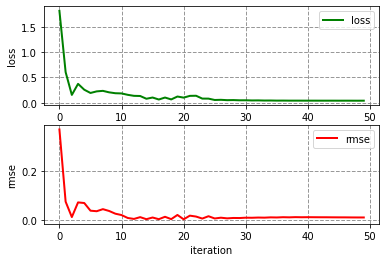

In [15]:
show_loss_rmse(loss_record, rmse_record, "apple_stock_price")

In [38]:
print(loss_record[-1], rmse_record[-1])

0.042036287 0.00552317


In [18]:
list(range(1, 10, 1))

[1, 2, 3, 4, 5, 6, 7, 8, 9]

# Influence of Sequence Length to Prediction (accuracy measured by rmse)

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
apple_training_complete = pd.read_csv(r'AAPL.csv')
apple_training_processed = apple_training_complete.iloc[:, 1:2].values #取第二列作为特征
scaler = MinMaxScaler(feature_range = (0, 1))
apple_training_scaled = scaler.fit_transform(apple_training_processed)

In [3]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.f1 = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.f2 = nn.LSTM(input_size=50, hidden_size=50, num_layers=1, batch_first=True)
        self.f3 = nn.LSTM(input_size=50, hidden_size=50, num_layers=1, batch_first=True)
        self.f4 = nn.Linear(50, 1)
        
    def forward(self, x):
        out1, (h_n, h_c) = self.f1(x, None) #(h0, c0)初始化为0
        out2, (h_n, h_c) = self.f2(out1, None)
        out3, (h_n, h_c) = self.f3(out2, None)
        out = self.f4(out3[:, -1, :])#忘加f2
        return out#忘记return

In [4]:
def get_sequence_features(seq_len):
    features_set, labels = [], []
    for i in range(seq_len, apple_training_scaled.shape[0]):
        features_set.append(apple_training_scaled[i-seq_len:i, 0]) #当前label的值取决于label前60天的股票值
        labels.append(apple_training_scaled[i, 0])
    features_set, labels = np.array(features_set), np.array(labels)
    #print(features_set.shape, labels.shape)
    features_set = features_set.astype(np.float32)
    labels = labels.astype(np.float32)
    features_set = torch.from_numpy(features_set)
    labels = torch.from_numpy(labels)

    features_set = features_set.view(features_set.shape[0], features_set.shape[1], 1)
    return features_set, labels

In [5]:
valid_ratio = 0.8
batch_size = 20
epoch_size = 30
lr = 1e-3
start_len = 55
end_len = 65

In [6]:
seq_len_list = list(range(start_len, end_len+1, 1)) #测试先验序列长度设为 55， 65之间时哪个预测的最准
loss_compare, rmse_compare = [], []

best_seq_len = start_len
min_rmse = 1e9

for seq_len in seq_len_list:

    features_set, labels = get_sequence_features(seq_len)
    train_num = int(features_set.shape[0] * valid_ratio)
    features_train, labels_train = features_set[ : train_num], labels[ : train_num]
    features_test, labels_test = features_set[train_num : ], labels[train_num : ]
    
    #print(features_train.shape, labels_train.shape, features_test.shape, labels_test.shape)
    train_dataset = Data.TensorDataset(features_train, labels_train)
    train_loader = Data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
    
    model = RNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.99))
    loss_func = torch.nn.MSELoss()
    
    loss_record = []
    rmse_record = []
    for epoch in range(epoch_size):
        loss_epoch = 0
        for x_train, x_label in train_loader:
            x_train = x_train.view(x_train.shape[0], -1, 1)
            output = model(x_train)
            #print(output.view(-1).shape, x_label.shape)
            #print(output.shape, labels.shape)
            loss_batch = loss_func(output.view(-1), x_label)
            loss_epoch += loss_batch
            optimizer.zero_grad()
            loss_batch.backward()
            optimizer.step()
        loss_record.append(loss_epoch.data.numpy())
        with torch.no_grad():
            output = model(features_test.view(features_test.shape[0], -1, 1))
            rmse = loss_func(output.view(-1), labels_test)
            rmse_record.append(rmse.data.numpy())
    
    if rmse_record[-1] < min_rmse:
        min_rmse = rmse_record[-1]
        best_seq_len = seq_len
        #print(min_rmse)

    loss_compare.append(loss_record[-1])
    rmse_compare.append(rmse_record[-1])
    
    print("Sequence Length is: {:} | Loss: {:4.4} | Rmse: {:4.4}".format(seq_len, loss_record[-1], rmse_record[-1]))

Sequence Length is: 55 | Loss: 0.04095 | Rmse: 0.005666
Sequence Length is: 56 | Loss: 0.04425 | Rmse: 0.004134
Sequence Length is: 57 | Loss: 0.05824 | Rmse: 0.004835
Sequence Length is: 58 | Loss: 0.04247 | Rmse: 0.004072
Sequence Length is: 59 | Loss: 0.06551 | Rmse: 0.004318
Sequence Length is: 60 | Loss: 0.05615 | Rmse: 0.00776
Sequence Length is: 61 | Loss: 0.04838 | Rmse: 0.00413
Sequence Length is: 62 | Loss: 0.04681 | Rmse: 0.00412
Sequence Length is: 63 | Loss: 0.05581 | Rmse: 0.004717
Sequence Length is: 64 | Loss: 0.04944 | Rmse: 0.004749
Sequence Length is: 65 | Loss: 0.05209 | Rmse: 0.006464


In [7]:
print("Best Sequence Length For Predicting Stock Price of Apple is {:}.".format(best_seq_len))

Best Sequence Length For Predicting Stock Price of Apple is 58.


# Compare different optimizer